In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import scipy
import scipy.linalg as linalg
np.set_printoptions(precision=2,suppress=True)

In [2]:
# calculations invisible
D = np.array([5,3,1])
y = np.array([2,5,3])
def ϕ(x):
    return np.row_stack((np.ones(x.shape[0]),x, x**2, x**3))
X=ϕ(D).T
print(X.T@X,X.T@y)

[[    3.     9.    35.   153.]
 [    9.    35.   153.   707.]
 [   35.   153.   707.  3369.]
 [  153.   707.  3369. 16355.]] [ 10.  28.  98. 388.]


# Regression When $p>n$
The global minimizers of the regression problem are given by
$$\{\bm{\beta}\in\mathbb{R}^p\mid X^\top X\bm{\beta} =X^\top\vvec{y} \}.$$

If the matrix $X^\top X$ is invertible, then there is only one minimizer:
$$\bm{\beta}= (X^\top X)^{-1}X^\top\vvec{y} $$

However, there also might be _infinitely many_ local and global minimizers of $RSS(\bm{\beta})$. 

````{prf:example} Regression with $p>n$
:label: example_regr_p_larger_n 
We consider a toy regression task, where the data is given by following three data points (observations) of one feature.

    D = np.array([5,3,1])
    y = np.array([2,5,3])
    pandas.DataFrame({"F1":D,"y":y})

That is, our given data looks as follows:
 
 $\mathtt{F}_1$ | $y$ 
----------------|----------------
5 | 2 
3 | 5 
1 | 3 

We fit a polynomial of degree $k=3$. For polynomial regression functions $f:\mathbb{R}\rightarrow\mathbb{R}$ we have
$$f(x) = \beta_0 +\beta_1 x+ \beta_2x^2 + \beta_3x^3 = \phi(x)^\top\bm\beta,$$
where 
$$\bm\phi(x)^\top=\begin{pmatrix}1& x& x^2& x^3\end{pmatrix}.$$

The design matrix gathers the transposed feature vectors of the data matrix:
$$X = \begin{pmatrix} \phi^\top(5)\\ \phi^\top(3)\\ \phi^\top(1)\end{pmatrix} = \begin{pmatrix} 1 & 5 & 25 & 125\\ 1 & 3 & 9 & 27\\ 1 & 1 & 1 & 1\end{pmatrix}$$
We have $n=3$ observations of $p=4$ features in the design matrix, and hence, $p>n$.



In this case ($p>n$), the matrix $X^\top X$ is not invertible. When you try to compute the inverse of $X^\top X$ by hand, then you will get a contradiction. If we compute the inverse numerically with `np.linalg.inv(X.T@X)`, then you will see that the computed "inverse" has extremely large values (in the scope of $10^13$ to $10^14$). This corresponds to the fact that we are trying to divide by zero (in a matrix way). Generally, you can assume that such extreme values (either being very close to zero like `1e-16` or very big like `1e16`) indicates values that are actually equal to infinity or equal to zero.

Anyways, we can easily check how good the computed inverse is, by multiplying the "inverse" with the matrix itself. The multiplication of the computed inverse and the matrix itself should return an approximate identity matrix. However, if we check `np.linalg.inv(X.T@X)@(X.T@X)`, then we see that this matrix is nowhere near the identity matrix.

In turn, what mostly works is to use a numerical solver for the system of linear equations which returns the global minimizers $\beta$ of the regression objective
$$\{\beta\in\mathbb{R}^p\mid X^\top X\beta = X^\top y\}.$$

With `β = linalg.solve(X.T@X,X.T@y)` yields a solution for $\beta$, but returns a warning that the result might not be accurate. We observe that this result is accurate and by checking if $X^\top X\beta = X^\top y$. You can do this  by inspecting `X.T@X@β, X.T@y`, which indeed returns the same vector.   
````

The example above shows that we can compute a solution for the regression problem in the case $p>n$, but how do we do that in general? Is there maybe a way to determine all the solvers $\beta$?

## Characterizing the Set of Regression Solvers with SVD
We have a look into the SVD of $X$ now, to have a closer look at what is going on with the regression equation if $X^\top X$ is not invertible. You might remember from the linear algebra recap, that the invertibility of a matrix is determined by the singular values of the matrix: if all the singular values are larger than zero, then the matrix is invertible, otherwise not. The singular values of $X^\top X$ are determined by the singular values of $X=U\Sigma V^\top$, since we have
\begin{align*}
    X^\top X = V\Sigma^\top \underbrace{U^\top U}_{=I} \Sigma V^\top = V\Sigma^\top \Sigma V^\top.
\end{align*}


 The singular value decomposition is uniquely defined and the decomposition $V\Sigma^\top \Sigma V^\top$ satisfies the requirements for the singular value decomposition of $X^\top X$. Hence, the singular values of $X^\top X$ are given by the diagonal elements of the matrix $\Sigma^\top \Sigma$. Let $r$ be the rank of the matrix $X$, that is the number of nonzero singular values. If $n<p$, then we know that $r\leq n$. That is, the matrix $\Sigma$ looks like
\begin{align}
\Sigma= 
\left(
\begin{array}{c:r}
\begin{matrix}
\sigma_1 & \ldots & 0  \\
\vdots  & \ddots  & \vdots \\
0 & \ldots   & \sigma_r \\
& \vvec{0} &
\end{matrix} & \vvec{0}
\end{array}
\right) 
= \left(
\begin{array}{c:r}
\begin{matrix}\Sigma_r\\\vvec{0}\end{matrix} & \vvec{0} \\ 
\end{array}
\right).
\label{eq:STS}
\end{align}

Given the singular value decomposition of $X$ and $X^\top X$, we can try to solve Eq.~\eqref{eq:minimizers} for $\bm\beta$:
\begin{align}
   X^\top X\bm{\beta} &= X^\top \vvec{y} \quad 
   \Leftrightarrow \quad V\Sigma^\top\Sigma V^\top \bm{\beta}= V\Sigma^\top U^\top\vvec{y}
   \quad 
   \Leftrightarrow \quad \Sigma^\top\Sigma V^\top \bm{\beta}= \Sigma^\top U^\top\vvec{y}, \label{eq:beta1}
\end{align}
where the last equality follows from multiplying with $V^\top$ from the left.

````{prf:observation} Characterization of Regression solvers by SVD
The global minimizers $\bm{\beta}$ to the linear regression problem with design matrix $X$, having the SVD $X=U\Sigma V^\top$, are given by
$$\{\bm{\beta}\in\mathbb{R}^p\mid \Sigma^\top\Sigma V^\top \bm{\beta}= \Sigma^\top U^\top\vvec{y} \}.$$
````
From this characterization of regression solvers follows that $\Sigma^\top\Sigma$ does **not** have an inverse if only $r<p$ singular values are nonzero. This is definitely the case if $n<p$, since we have at most $\min\{n,p\}$ nonzero singular values of a $n\times p$ matrix. 

````{prf:theorem} Getting all regression solvers
The global minimizers $\bm{\beta}$ to the linear regression problem with design matrix $X$, having the SVD $X=U\Sigma V^\top$, are given by
$$\{\bm{\beta}= V\begin{pmatrix}\Sigma_r^{-1} U_r^\top\vvec{y}\\z\end{pmatrix}\mid z\in\mathbb{R}^{p-r} \}.$$
````
````{toggle}
```{prf:proof}
We start at the characterization of regression solvers by SVD (Observation):
\begin{align}
\Sigma^\top\Sigma V^\top\bm\beta &= \Sigma^\top U_r^\top y\\
\Leftrightarrow
\left(\begin{array}{cc}
\begin{matrix}
\Sigma_r&\vvec{0}\end{matrix} \\\hdashline \vvec{0} 
\end{array}\right)
\left(
\begin{array}{c:r}
\begin{matrix}\Sigma_r\\\vvec{0}\end{matrix} & \vvec{0} \\ 
\end{array}
\right)
V^\top \bm\beta &=  \left(\begin{array}{cc}
\begin{matrix}
\Sigma_r&\vvec{0}\end{matrix} \\\hdashline \vvec{0} 
\end{array}\right) U_r^\top y
\end{align}
We see here that only the first $r$ equations are relevant, the remaining equations $0=0$ are evidently true. We further shorten the notation by setting $\hat{\bm\beta}=V^\top\bm\beta$. We have then
\begin{align}
\Sigma_r\begin{pmatrix} \Sigma_r & \vvec{0}\end{pmatrix}\hat{\bm\beta} &= \Sigma_r U_r^\top y\\ 
\Leftrightarrow
\begin{pmatrix} \Sigma_r & \vvec{0}\end{pmatrix}\hat{\bm\beta} &= U_r^\top y\\ 
\Leftrightarrow
\begin{pmatrix} I_r & \vvec{0}\end{pmatrix}\hat{\bm\beta} &= \Sigma_r^{-1} U_r^\top y\\
\Leftrightarrow
\hat{\bm\beta}_{0:r} &= \Sigma_r^{-1} U_r^\top y
\end{align}
We see that only the first $r$ coordinates of $\hat{\bm\beta}$ are determined by the given equation. What we have in the rest of the coordinates is free to choose and the equation will still hold. We model the coordinates that are free to choose with the vector $z$. Then we have

\begin{align}
\hat{\bm\beta} &= \begin{pmatrix}\Sigma_r^{-1} U_r^\top y\\z \end{pmatrix}\\
\Leftrightarrow V^\top\bm\beta &= \begin{pmatrix}\Sigma_r^{-1} U_r^\top y\\z \end{pmatrix}\\
\Leftrightarrow \bm\beta &= V\begin{pmatrix}\Sigma_r^{-1} U_r^\top y\\z \end{pmatrix}
\end{align}

```
````

## Example Determination of Regression Solvers by SVD
We consider again the data from {prf:ref}`example_regr_p_larger_n `.

In [3]:
D = np.array([5,3,1])
y = np.array([2,5,3])
def ϕ(x):
    return np.row_stack((np.ones(x.shape[0]),x, x**2, x**3))
X=ϕ(D).T
U,σs,Vt = linalg.svd(X, full_matrices=True)
print(U.shape, σs.shape, Vt.shape)
V=Vt.T

(3, 3) (3,) (4, 4)


When we look at the singular values, then we have $r=3<4=p$.

In [4]:
σs

array([130.7 ,   4.2 ,   0.84])

Correspondingly, the matrix $\Sigma^\top\Sigma$ (computed below) has not an inverse.

In [5]:
Σ = np.column_stack((np.diag(σs),np.zeros(3)))
Σ

array([[130.7 ,   0.  ,   0.  ,   0.  ],
       [  0.  ,   4.2 ,   0.  ,   0.  ],
       [  0.  ,   0.  ,   0.84,   0.  ]])

In [6]:
Σ.T@Σ

array([[17081.66,     0.  ,     0.  ,     0.  ],
       [    0.  ,    17.63,     0.  ,     0.  ],
       [    0.  ,     0.  ,     0.71,     0.  ],
       [    0.  ,     0.  ,     0.  ,     0.  ]])

How is that reflected in the system of linear equations that we have to solve?

In [7]:
print(Σ.T@Σ@V.T,"β=",Σ.T@U@y)

[[  157.18   724.22  3445.93 16714.05]
 [   -4.36    -8.61   -14.36     3.38]
 [    0.58     0.25    -0.32     0.05]
 [    0.       0.       0.       0.  ]] β= [415.45 -21.56   1.04   0.  ]


\begin{align*}
\Sigma^\top \Sigma V^\top \beta &= \Sigma^\top U \vvec{y}\\ \\
\begin{pmatrix}
 157.18 &   724.22 &  3445.93 & 16714.05\\
 -4.36  &  -8.61  & -14.36   &  3.38\\
 0.58   & 0.25   & -0.32    & 0.05\\
 0      & 0      & 0        & 0
\end{pmatrix}
\beta &= 
\begin{pmatrix}
415.45 \\ -21.56 \\ 1.04 \\   0
\end{pmatrix}
\end{align*}

We have an underdetermined system. There are only 3 equations to determine 4 parameters of $\beta$. If you are going to solve this system by hand, then you will see that one parameter is always left over (it can't be determined by the given equations). Setting this parameter to any number yields then one of the infinite solutions to the regression problem. For example, we can set $\beta_4=2$.  

We can now calculate a $\beta$ in the set of global minimizers. If ```random=True``` then a random matrix replaces the zero rows in the pseudo inverse of $\Sigma^\top\Sigma$.

In [8]:
def get_beta(U,Σ,V,random =True):
    Σ_pseudoinv = Σ.copy()
    Σ_pseudoinv[Σ>0] = 1/Σ[Σ>0]
    w = Σ_pseudoinv.T@U.T@y
    if random:
        p=V.shape[1]
        r=(Σ>0).sum() # the number of nonzero singular values
        w[r:p]=np.random.rand(p-r)*50
    return V@w

Plot it! The function resulting from setting ```random=False``` is the one in blue.

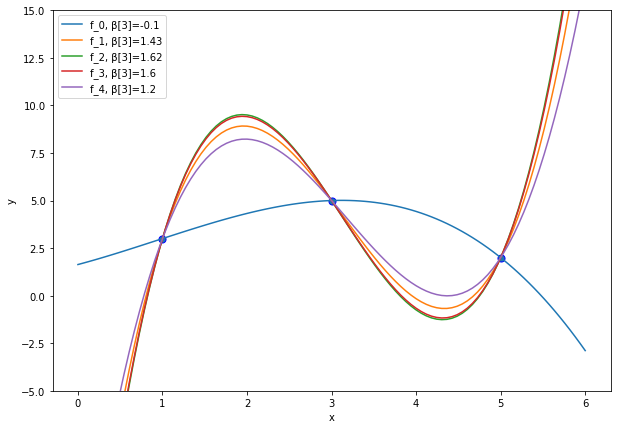

In [9]:
plt.figure(figsize=(10, 7))
x = np.linspace(0, 6, 100)
β = get_beta(U,Σ,V,random = False)
f_x = ϕ(x).T@β
plt.plot(x, f_x, label="f_0"+", β[3]="+str(np.round(β[3],2)))
for i in range(1,5):
    β = get_beta(U,Σ,V)
    f_x = ϕ(x).T@β
    plt.plot(x, f_x, label="f_"+str(i)+", β[3]="+str(np.round(β[3],2)))
plt.scatter(D, y, edgecolor='b', s=50)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim((-5, 15))
plt.legend(loc="best")
plt.show()